In [1]:
import string

#Importing pandas
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import nltk
from nltk import tokenize
#Remove stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

#SKLearn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import metrics

#We will shuffle the data to prevent bias
from sklearn.utils import shuffle
#Sklearn to pipeline
from sklearn.pipeline import Pipeline
#Sklearn to CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
#Logistic regression
from sklearn.linear_model import LogisticRegression
#Accuracy score
from sklearn.metrics import accuracy_score
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
#Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

from scipy.stats import entropy

from wordcloud import WordCloud

#For the confusion matrix
import itertools

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\homol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Select the file I will work
fake = pd.read_csv('RealFakeNews/Fake.csv')
true = pd.read_csv('RealFakeNews/True.csv')

In [3]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
#Then we add a flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [6]:
#Now let’s concatenate the data frames
data = pd.concat([fake, true]).reset_index(drop = True)

In [7]:
#We will shuffle the data to prevent bias
data = shuffle(data)
data = data.reset_index(drop=True)

In [8]:
#Removing the date (we won’t use it for the analysis)
data.drop(['date'],axis=1,inplace=True)

In [9]:
#Removing the title (we will only use the text)
data.drop(['title'],axis=1,inplace=True)

In [10]:
#Convert the text to lowercase
data['text'] = data['text'].apply(lambda x : x.lower())

In [11]:
#Remove punctuation
def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str
data['text'] = data['text'].apply(punctuation_removal)

In [12]:
#Remove stopwords
#import nltk
#nltk.download('stopwords')
#from nltk.corpus import stopwords
stop = stopwords.words('english')
data['text'] = data['text'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stop)]))

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


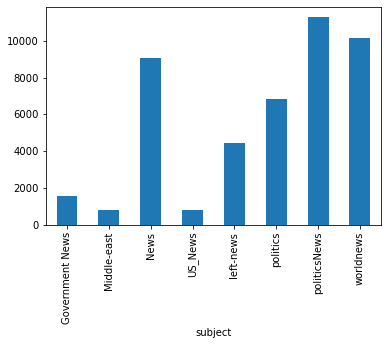

In [13]:
#Data Exploration
#How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind='bar')
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


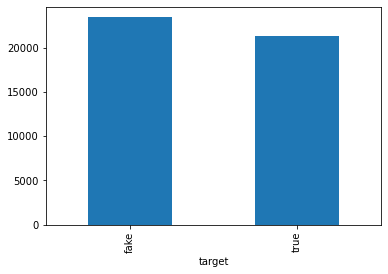

In [14]:
#How many fake and real articles
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind='bar')
plt.show()

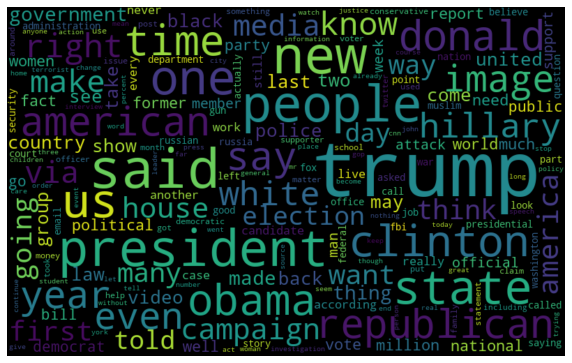

In [15]:
#Word Cloud for fake news
fake_data = data[data['target'] == 'fake']
all_words = ' '.join([text for text in fake_data.text])
wordcloud = WordCloud(width= 800, height= 500, max_font_size = 110, collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

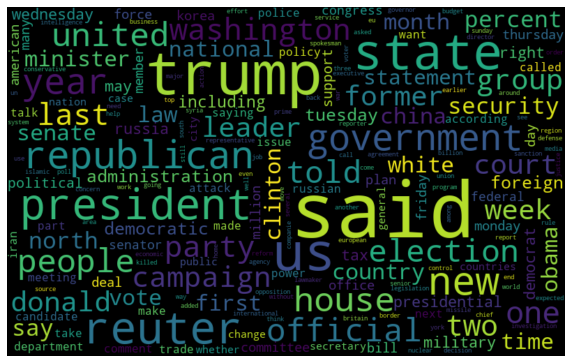

In [16]:
#Word Cloud for real news
fake_data = data[data['target'] == 'true']
all_words = ' '.join([text for text in fake_data.text])
wordcloud = WordCloud(width= 800, height= 500, max_font_size = 110, collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [17]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
token_space = tokenize.WhitespaceTokenizer()
def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()), "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

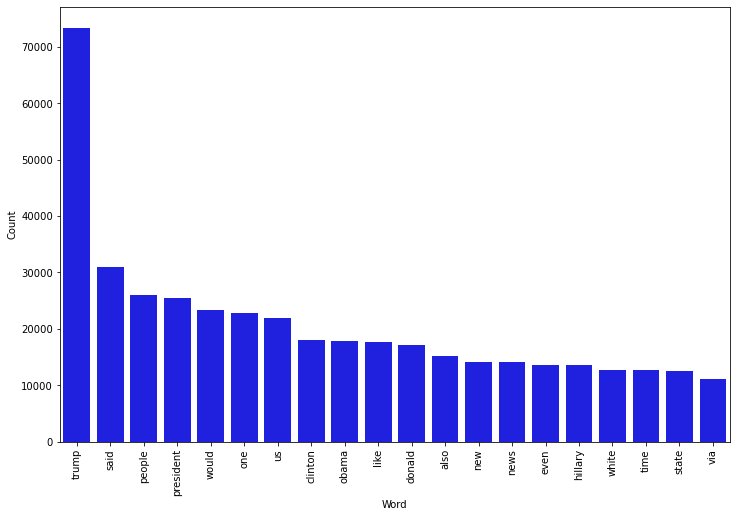

In [18]:
#Most frequent words in fake news
counter(data[data['target'] == 'fake'], 'text', 20)

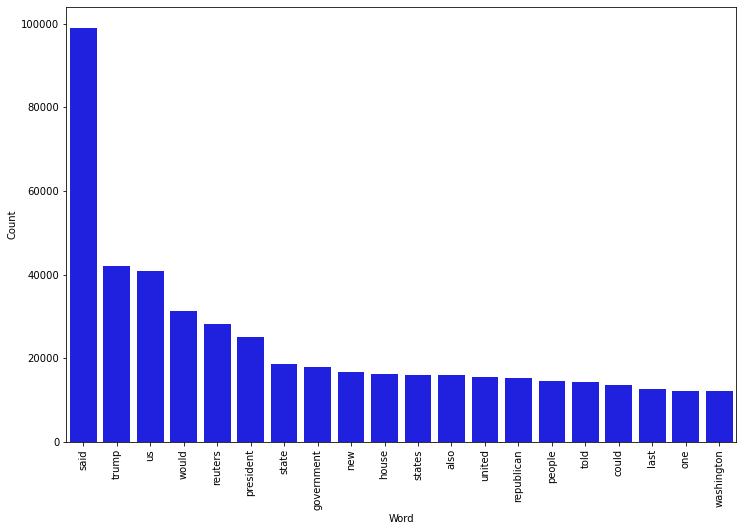

In [19]:
#Most frequent words in real news
counter(data[data['target'] == 'true'], 'text', 20)

In [20]:
#Modeling
#The modeling process will consist of vectorizing the corpus stored in the “text” column, then applying TF-IDF, and finally a classification machine learning algorithm. Pretty standard in text analytics and NLP.
#For modeling, we have this function to plot the confusion matrix of the models

# Function to plot the confusion matrix (code from httpsscikit-learn.orgstableauto_examplesmodel_selectionplot_confusion_matrix.html)
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
        thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
#Split the data (Sklearn)
X_train, X_test, y_train, y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

In [22]:
# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

In [23]:
# Fitting the model
model = pipe.fit(X_train, y_train)

In [24]:
# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 98.96%


Confusion matrix, without normalization


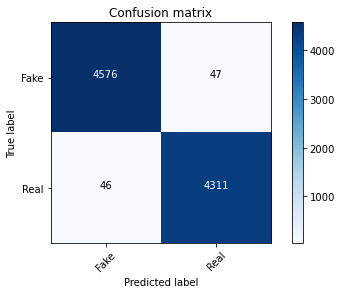

In [25]:
#I got an accuracy of 98.76%. The confusion matrix
cm = metrics.confusion_matrix(y_test, prediction) 
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [26]:
#Decision Tree Classifier
# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('model', DecisionTreeClassifier(criterion= 'entropy', max_depth = 20, splitter='best', random_state=42))])

Confusion matrix, without normalization


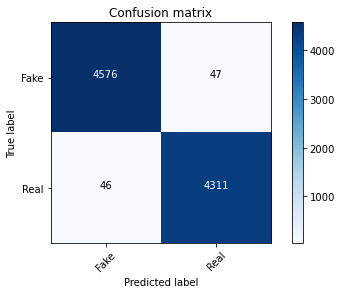

In [27]:
#I got an accuracy of 99.71 %. The confusion matrix
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])